In [2]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
# local
import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')

from datasets.import_dataset import import_dataset
from trainer import Trainer
from utils.plotting import *
from utils import utils
import datasets.simulations as sim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')


%load_ext autoreload
%autoreload 2

device = cuda


In [ ]:
# densification for link prediction: take a subgraph that is not
# link prediction: i know some of the nodes and a bunch is dyads on which i need to predict. so take a subgraph 



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:304:::  
 2024-09-16 14:15:50 starting optimization of iegam on photo on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 30,
        "dim_attr": 500,
        "s_reg": 0.0,
        "l1_reg": 1,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-06,
        "n_iter": 20000,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 9999


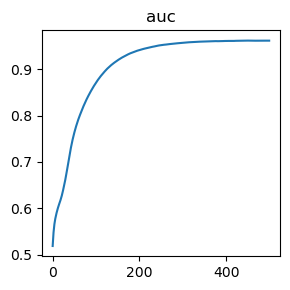



/home/user/Documents/danny/AAAI_pieclam/experiments/../clamiter.py:369:::  
fit wrapper fit_feats, plotting state at iter 19999


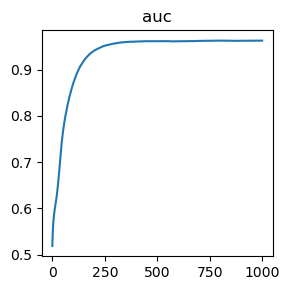



/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:421:::  


FINISHED train 
 last accuracies:
auc: 0.962949958280846


/home/user/Documents/danny/AAAI_pieclam/experiments/../trainer.py:427:::  





In [13]:
# train = 85% val = 5% test = 10%
# need to omit 15% of the nodes, then run accuracy on the 5% validation set



#todo:DENSIFICATION send the dyads to omit as a dict of val dyads and test dyads. make sure that they all get omitted and keep sending them down until you reach the acc track

photo_ds = import_dataset('photo')
photo_ds.edge_index.shape
#todo: no choice: change the get_dyads_to_omit function to omit only dyads that werent omitted. ones that 
dyads_to_omit = utils.get_dyads_to_omit(photo_ds.edge_index, 0.15)


# todo: make the train test split something that i can control from the outside.
# todo: make densification 


trainer_photo_ieclam = Trainer(
                        dataset=photo_ds,
                        model_name='iegam',
                        task='link_prediction',
                        device=device,
)

losses, acc_test, acc_val = trainer_photo_ieclam.train(
            init_type='small_gaus',
            init_feats=True,
            dyads_to_omit=dyads_to_omit,
            val_rel_size=0.3,
            acc_every=20,
            plot_every=10000,
            verbose=False,
            verbose_in_funcs=False
        )


In [7]:
acc_test['auc'][-1]
# max(acc_test['auc'])

0.957783663587745